# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import face_recognition
import ipywidgets as widgets
import matplotlib.pyplot as mp

from IPython.display import display 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from PIL import Image

# Preparing the Datasets

In [2]:
df = pd.read_csv("../../illinois/person.csv", sep = ";")
pd.set_option("display.max_columns", None)
df = df.dropna(subset=['weight', 'height'])
df = df.drop(columns=['date_of_birth', 'hair', 'sex', 'race', 'eyes', 'admission_date', 'projected_parole_date', 
              'last_paroled_date', 'projected_discharge_date', 'parole_date', 'electronic_detention_date', 
              'discharge_date', 'parent_institution', 'offender_status', 'location', 'sex_offender_registry_required',
             'alias', 'Unnamed: 21'])
df = df.reset_index(drop=True)
df['bmi'] = df['weight'] * 703 / df['height']**2

## Code Explanation
The original dataset comes with images of the prisoners, their height, and their weight. According to the dataset creator, the height has been processed to contain the height in inches, as opposed to the height in feet and inches. Likewise, the weight has been altered from "xxx lbs." to "xxx". The rows with the height or weight missing (marked as "N/A" in the dataset) are dropped. Here, I created a new column called bmi using the formula of weight * 703 / height * height. The newly created column will be the label column, which the model will try to predict.

In [3]:
dfow = df.loc[(df['bmi'] >= 25) & (df['bmi'] < 30)]
dfob = df.loc[(df['bmi'] >= 30)]
dfno = df.loc[(df['bmi'] >= 18.5) & (df['bmi'] < 25)]
dfuw = df.loc[(df['bmi'] < 18.5)]
dfuw = dfuw.reset_index(drop=True)
dfno = dfno.reset_index(drop=True)
dfow = dfow.reset_index(drop=True)
dfob = dfob.reset_index(drop=True)
dfob = dfob.drop(dfob.index[2000:])
dfow = dfow.drop(dfow.index[2000:])
dfno = dfno.drop(dfno.index[2000:])
dfuw = dfuw.drop(dfuw.index[2000:])

In [4]:
df_merged = pd.concat([dfow, dfno, dfob, dfuw], ignore_index=True, sort=False)
df_merged.head()

id              name  weight  height        bmi
0  A00147  MCCUTCHEON, JOHN   185.0    67.0  28.971931
1  A01054   TIPTON, DARNELL   166.0    67.0  25.996436
2  A01072    BRISBON, HENRY   195.0    69.0  28.793321
3  A01077     JONES, ROBERT   180.0    68.0  27.365917
4  A01157  LANGFORD, ROBERT   207.0    72.0  28.071181

## Code Explanation
To ensure a well-balanced dataset, I used 2000 rows of prisoners of each weight status (underweight, normal, overweight, and obese) and combine them into a single dataframe (df_merged).

# Data Visualizations

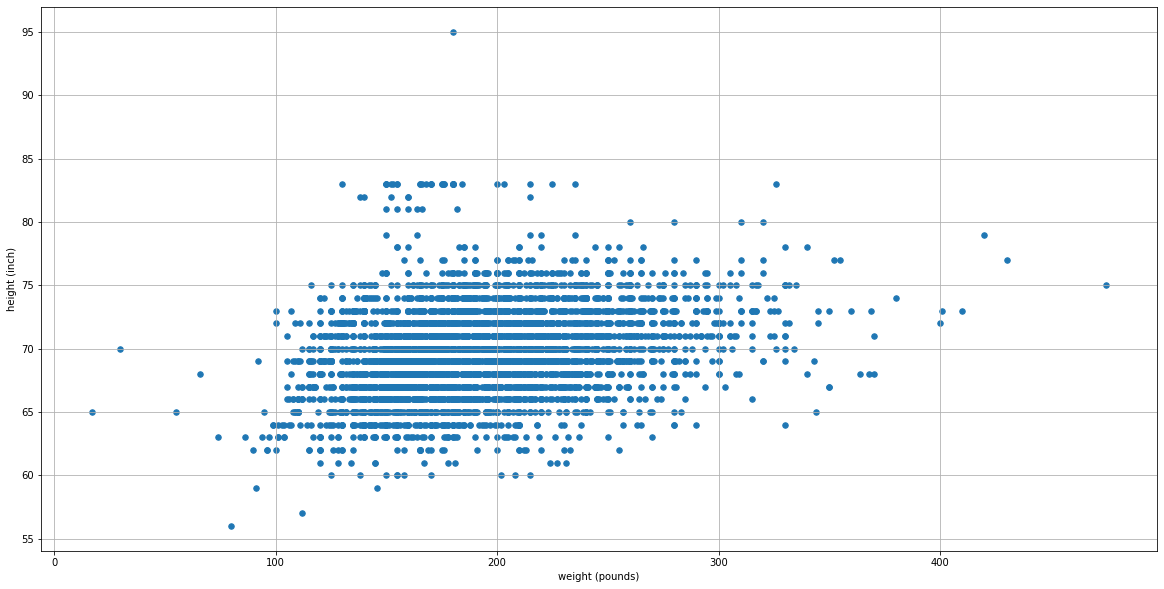

In [5]:
mp.figure(figsize=(20,10))
mp.scatter(x= df_merged['weight'], y=df_merged['height'], s = 30)
mp.grid(True)
mp.xlabel("weight (pounds)")
mp.ylabel("height (inch)")

mp.show()

In [6]:
print("Average Height: " + str(df_merged['height'].mean() * 2.54) + " cm")
print("Average Weight: " + str(df_merged['weight'].mean() / 2.205) + " kg")

Average Height: 177.21532680770443 cm
Average Weight: 86.81399093686522 kg


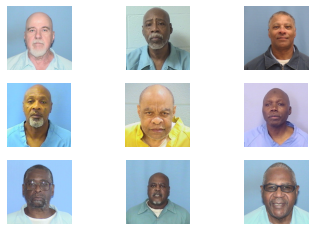

In [7]:
x = 1
for imag in df_merged.id:
    if x < 10:
        image = face_recognition.load_image_file('../../illinois/front/front/'+imag+'.jpg')
        pyplot.subplot(3, 3, x)
        pyplot.axis("off")
        pyplot.imshow(image)
        x = x+1
    
pyplot.show()

## Code Explanation
Here, we can see the pictures of the prisoners. We will extract the face encodings from these pictures before using the face encodings as the predictor of our Support Vector Regression model.

# Generating Face Encodings

In [8]:
def face_into_encoding(path, filename):
    image = face_recognition.load_image_file(path)
    face_encoding = face_recognition.face_encodings(image)
    if not face_encoding:
        print("Cannot find face " + filename + ".jpg")
        return np.zeros(128).tolist()
    return face_encoding[0].tolist()

## Code Explanation
First, the image is loaded by using the load_image_file function provided by the face_recognition library. Then, the face encoding is extracted (if a face exists inside the image) in the form of a vector of 128 values.

In [9]:
face_encoded_list = []
for imag in df_merged.id:
    face_encoded = face_into_encoding('../../illinois/front/front/'+imag+'.jpg', imag)
    face_encoded_list.append(face_encoded)

Cannot find face A63742.jpg
Cannot find face A70170.jpg
Cannot find face A74143.jpg
Cannot find face A81850.jpg
Cannot find face A83405.jpg
Cannot find face A95046.jpg
Cannot find face B03191.jpg
Cannot find face B04516.jpg
Cannot find face B04962.jpg
Cannot find face B05972.jpg
Cannot find face B09213.jpg
Cannot find face B10636.jpg
Cannot find face B11390.jpg
Cannot find face B13502.jpg
Cannot find face B18634.jpg
Cannot find face B20449.jpg
Cannot find face B20964.jpg
Cannot find face B21338.jpg
Cannot find face B21460.jpg
Cannot find face B34441.jpg
Cannot find face B34553.jpg
Cannot find face B36110.jpg
Cannot find face A00220.jpg
Cannot find face A10157.jpg
Cannot find face A56106.jpg
Cannot find face A61010.jpg
Cannot find face A61982.jpg
Cannot find face A68718.jpg
Cannot find face A70208.jpg
Cannot find face A81652.jpg
Cannot find face A82134.jpg
Cannot find face A82875.jpg
Cannot find face A86277.jpg
Cannot find face A90976.jpg
Cannot find face A91256.jpg
Cannot find face A91

## Code Explanation
Here, if the face_encodings function provided by the face_recognition library cannot find the face and extract the encodings inside the image, it will return a numpy array of zeros with a shape of 128.

# Train Test Split

In [10]:
X = np.array(face_encoded_list)
y = df_merged.bmi.values

In [11]:
X

array([[-0.01044655,  0.05829509,  0.06655686, ...,  0.06032772,
         0.03906845,  0.04637595],
       [-0.15689363,  0.13439138,  0.13344234, ...,  0.03049208,
         0.01006431,  0.05763209],
       [-0.08309831,  0.20680046,  0.05470552, ..., -0.0065851 ,
         0.05044679,  0.00131647],
       ...,
       [-0.05691046,  0.06068989, -0.01033795, ...,  0.06498437,
         0.08019906,  0.01637756],
       [-0.17689793,  0.13379836, -0.02723971, ..., -0.00624102,
         0.09222589,  0.02983412],
       [-0.09017763,  0.04706919, -0.00897193, ..., -0.08093235,
         0.03196023,  0.04580639]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Code Explanation
Here, train_test_split function provided by sklearn library is used to split the dataset into train and test. By default, the split would be 0.75 of the dataset for train and 0.25 of the dataset for test.

# Training the Model

In [13]:
from sklearn import svm
from sklearn.metrics import mean_absolute_error

svr_model = svm.SVR()
svr_model = svr_model.fit(X_train, np.log(y_train))
y_pred_train = svr_model.predict(X_train)
y_pred_test = svr_model.predict(X_test)
print("Mean Absolute Error of the Train Dataset: " + str(mean_absolute_error(y_train, np.exp(y_pred_train))))
print("Mean Absolute Error of the Test Dataset: " + str(mean_absolute_error(y_test, np.exp(y_pred_test))))

Mean Absolute Error of the Train Dataset: 3.3871646712880574
Mean Absolute Error of the Test Dataset: 3.7796482729876892


## Code Explanation
Here, the Support Vector Regression algorithm is fitted to the train dataset. After the model is trained, it can be used to predict the entirety of the train and test dataset. As we can see above, there's not much of a difference between the MAE of the train dataset and the MAE of the test dataset (0.4 kg/m2). Therefore, we know that the model is not overfitted for the train dataset.

# Hyperparameter Fine-Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
epsilon = [0.1, 0.2, 0.4, 0.7, 1]
gamma = ['scale', 0.1, 0.2, 0.5, 0.7, 1]
C = [int(x) for x in np.arange(1, 100, 20)]
grids = {'kernel' : kernel,
            'epsilon' : epsilon,
             'gamma' : gamma,
            'C' : C}

In [15]:
svr_model_tuned = GridSearchCV(estimator=svm.SVR(), param_grid=grids, cv = 4, n_jobs=-1, scoring="neg_mean_absolute_error")
svr_model_tuned.fit(X_train, np.log(y_train))
y_predictions_train = svr_model_tuned.predict(X_train)
y_predictions_test = svr_model_tuned.predict(X_test)
print("Mean Absolute Error of the Train Dataset After Tuning: " 
      + str(mean_absolute_error(y_train, np.exp(y_predictions_train))))
print("Mean Absolute Error of the Test Dataset After Tuning: " 
      + str(mean_absolute_error(y_test, np.exp(y_predictions_test))))

Mean Absolute Error of the Train Dataset After Tuning: 3.4120268710265007
Mean Absolute Error of the Test Dataset After Tuning: 3.7785165351319194


## Code Explanation
Here, we try to improve the MAE score even further by doing hyperparameter fine-tuning. We used GridSearchCV with 4 folds, with the total number of combinations being 4 * 5 * 6 * 5 * 4 = 2400. Each of the parameters has different purposes. An example would be the C parameter, which is the cost penalty parameter. A high C would pay too much attention to the training dataset, which in turn would lead to the model not being able to handle unseen data well. A low C could oversimplify the model, leading to a high error rate on both train and test dataset. Visit the documentation of SVR by scikit-learn for more information regarding the rest of the parameters.

As we can see from the output above, the MAE of the train dataset is higher than before tuning. However, the MAE of the test dataset is lower compared to the model before fine-tuning, which means the fine-tuned model has been simplified and can handle unseen data better.

# Testing the Model

In [16]:
def predict_bmi(X_images, model, filename):
    X = np.expand_dims(np.array(face_into_encoding(X_images, filename)), axis=0)
    log_value = model.predict(X)
    bmi = np.exp(log_value)
    return bmi

In [17]:
images = os.listdir('../../bmitrial')
for img in images:
    img_location = '../../bmitrial/' + img
    img = open(img_location, 'rb')
    test_img = img.read()
    preds = predict_bmi(img_location, svr_model_tuned, img)
    display(widgets.Image(value=test_img, format='jpg', width=200, height=200))
    print("Your BMI is: " + str(round(preds[0], 2)) + "kg/m2")

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00K\x00K\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\…

Your BMI is: 18.36kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xc8\x00\xc8\x00\x00\xff\xdb\x00C\x00\x06\x04\x0…

Your BMI is: 16.47kg/m2


Image(value=b'\xff\xd8\xff\xe1\x1f\x08Exif\x00\x00II*\x00\x08\x00\x00\x00\x11\x00\x00\x01\x03\x00\x01\x00\x00\…

Your BMI is: 34.64kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00VExif\x00\x00MM\x00*\x…

Your BMI is: 39.81kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x0…

Your BMI is: 22.48kg/m2


Image(value=b'\xff\xd8\xff\xe1\xff\xfeExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0f\x00\x02\x00\x00\x00\x1…

Your BMI is: 29.4kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0…

Your BMI is: 43.12kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00zExif\x00\x00II*\x00\x…

Your BMI is: 20.55kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00\x84\x00\x04\x03\x03\x…

Your BMI is: 38.62kg/m2


Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\…

Your BMI is: 31.46kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00;\x00;\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\…

Your BMI is: 30.94kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x05\x03…

Your BMI is: 38.85kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00\xc0Exif\x00\x00II*\x0…

Your BMI is: 33.59kg/m2


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x02@ICC_PROFILE\x00\x01\x…

Your BMI is: 21.01kg/m2


Image(value=b'RIFF~M\x00\x00WEBPVP8 rM\x00\x00\xf0&\x01\x9d\x01*\x86\x01\x18\x01>1\x16\x89C"!!\x12x\xd6\xb0 \x…

Your BMI is: 34.06kg/m2


## Code Explanation
Previously, we have known that the fine-tuned model has an MAE of 3.78 kg/m2. Here, I tested the model on a few images of a person with a case of obesity and malnutrition.